# Predict

### Load Model

In [1]:
import os
from parameters import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.keras.models import load_model

2024-10-14 23:40:06.179303: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 23:40:06.179394: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 23:40:06.179402: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
if KERAS_TUNER: 
    best_model_file = 'model/best_keras_model.h5'
else:
    # Define shape based on parameters file neurons
    model_shape = 'mlp_602_'
    model_shape += '_'.join(str(l) for l in NEURONS_PER_LAYER)
    model_shape += '_10'

    best_model_file = 'model/{}_best_model.h5'.format(model_shape)
                                                       

In [3]:
print(best_model_file)

model/mlp_602_3700_4500_4900_10_best_model.h5


In [4]:
# Load the best model that we have saved from previous script
model = load_model(best_model_file)

## Process Measurements

### Load data

In [5]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [6]:
filename = 'test_measurements/rvtnMeasurementData.csv'
df = pd.read_csv(filename)
dataId = df.iloc[:, 1].to_numpy()
dataVg = df.iloc[:, 0].to_numpy()  

In [7]:
# Load test data for comparison
X_test = np.asarray(np.load('{}/npy/x_{}_test.npy'.format(DATA_DIR, PARAM), allow_pickle=True))

In [8]:
# Load test data for comparison
y_test = np.asarray(np.load('{}/npy/y_{}_test.npy'.format(DATA_DIR, PARAM), allow_pickle=True))

In [9]:
# Ensure Vg values are the same as training data
print('Measurement Vg 1: ', dataVg[0], 'Training/test Vg 1: ', X_test[0][0][0])
print('Measurement Vg Len: ', len(dataVg), 'Training/test Vg Len: ', len(X_test[0][0]))
print('Measurement Vg 300: ', dataVg[300], 'Training/test Vg 300: ', X_test[0][0][300])

Measurement Vg 1:  0.1 Training/test Vg 1:  0.1
Measurement Vg Len:  301 Training/test Vg Len:  301
Measurement Vg 300:  1.0 Training/test Vg 300:  1.0


### Transform Data

Here we will set everything below the noise floor to 0, and log scale just like what was done for training data

In [10]:
'''#look at test data prediction
testIndex=2002
print(X_test[testIndex][2])
dataId = np.asarray(X_test[testIndex][2])'''

'#look at test data prediction\ntestIndex=2002\nprint(X_test[testIndex][2])\ndataId = np.asarray(X_test[testIndex][2])'

In [11]:
# Set values below measurement noise floor to global_min, So we prepare the model for the input measurement data
if MYSTIC_MC:
    noiseFloor = -1e-10 #rvtnfets
    
    # find minimum value for data we want to measure and set that to minimum so it doesnt learn any misleading information
    filename = 'test_measurements/rvtnMeasurementData.csv'
    df = pd.read_csv(filename)
    dataId_meas = df.iloc[:, 1].to_numpy()
    
    dataId_meas = np.where(dataId_meas < noiseFloor, 0, dataId_meas)
    valid_values = dataId_meas[dataId_meas != 0]
    global_min = np.min(valid_values)
 
    dataId = np.where(dataId < noiseFloor, global_min, dataId)
else:
    noiseFloor = 1e-10 #rvtnfets
    
    # find minimum value for data we want to measure and set that to minimum so it doesnt learn any misleading information
    filename = 'test_measurements/rvtnMeasurementData.csv'
    df = pd.read_csv(filename)
    dataId_meas = df.iloc[:, 1].to_numpy()
    
    dataId_meas = np.where(dataId_meas < noiseFloor, 0, dataId_meas)
    valid_values = dataId_meas[dataId_meas != 0]
    global_min = np.min(valid_values)
 
    dataId = np.where(dataId < noiseFloor, global_min, dataId)

In [12]:
# Log scale
dataId_log = np.log(dataId)

### Scale Data

In [13]:
# Need to import scaling function, open terminal--> pip install import_ipynb
import import_ipynb
from ml_custom_scaler import Scaler

importing Jupyter notebook from ml_custom_scaler.ipynb


In [14]:
scaler = Scaler()

In [15]:
# Grab scaling Values we used for all of the training data

filename = 'scaling_boundaries.txt'
with open(filename, 'r') as file:
        boundaries = {}
        
        for line in file:
            key_value = line.strip().split(': ')
            if len(key_value) == 2:
                key = key_value[0] 
                value = float(key_value[1]) 
                boundaries[key] = value 

min_lin = boundaries['min_lin']
max_lin = boundaries['max_lin']
min_log = boundaries['min_log']
max_log = boundaries['max_log']

print("Min Linear:", min_lin)
print("Max Linear:", max_lin)
print("Min Log:", min_log)
print("Max Log:", max_log)

Min Linear: 1e-10
Max Linear: 1.983e-05
Min Log: -23.025850929940457
Max Log: -10.82831461543257


In [16]:
# Use these values to scale the measurement data

dataId_scaled, global_min, global_max = scaler.scale(dataId, global_min=float(min_lin), global_max=float(max_lin))
dataId_scaled_log, global_min_log, global_max_log = scaler.scale(dataId_log, global_min=float(min_log), global_max=float(max_log))

Using provided global min: 1e-10
Using provided global max: 1.983e-05
Using provided global min: -23.025850929940457
Using provided global max: -10.82831461543257


In [17]:
print(dataId)
#none of the training data is this high, there is a problem with the training set

[1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10
 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10
 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10
 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10
 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10
 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10
 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10
 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10
 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10
 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10
 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10
 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10
 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10
 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e-10 1.77e

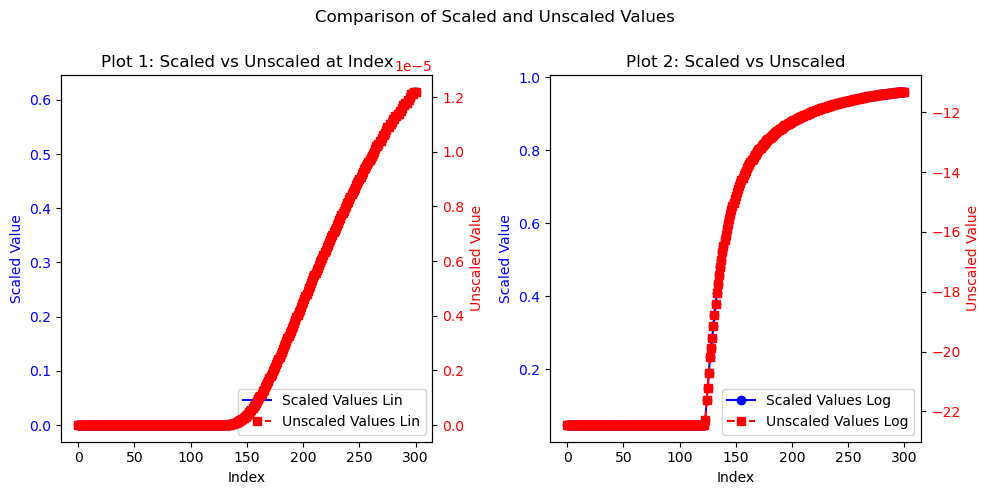

In [18]:
# Plot the scaled vs unscaled list 
# Assuming scaled_x and X_drain_current are pre-defined DataFrames

sample_scaled_values_1 = dataId_scaled
sample_unscaled_values_1 = dataId

# Create a new set of sample data for the second plot
sample_scaled_values_2 = dataId_scaled_log
sample_unscaled_values_2 = dataId_log

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First plot
line1_1, = ax1.plot(sample_scaled_values_1, marker='o', linestyle='-', color='b', label='Scaled Values Lin')
ax1.set_xlabel('Index')
ax1.set_ylabel('Scaled Value', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1_twin = ax1.twinx()

line1_2, = ax1_twin.plot(sample_unscaled_values_1, marker='s', linestyle='--', color='r', label='Unscaled Values Lin')
ax1_twin.set_ylabel('Unscaled Value', color='r')
ax1_twin.tick_params(axis='y', labelcolor='r')

lines_1 = [line1_1, line1_2]
ax1.legend(lines_1, [line.get_label() for line in lines_1], loc='lower right')
ax1.set_title('Plot 1: Scaled vs Unscaled at Index')

# Second plot
line2_1, = ax2.plot(sample_scaled_values_2, marker='o', linestyle='-', color='b', label='Scaled Values Log')
ax2.set_xlabel('Index')
ax2.set_ylabel('Scaled Value', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2_twin = ax2.twinx()

line2_2, = ax2_twin.plot(sample_unscaled_values_2, marker='s', linestyle='--', color='r', label='Unscaled Values Log')
ax2_twin.set_ylabel('Unscaled Value', color='r')
ax2_twin.tick_params(axis='y', labelcolor='r')

lines_2 = [line2_1, line2_2]
ax2.legend(lines_2, [line.get_label() for line in lines_2], loc='lower right')
ax2.set_title('Plot 2: Scaled vs Unscaled')

plt.tight_layout()
plt.suptitle('Comparison of Scaled and Unscaled Values')
plt.subplots_adjust(top=0.85)  
plt.show()

In [19]:
# Append log scale to end of lin scale data
lin_log_measurements = np.concatenate([dataId_scaled, dataId_scaled_log])
print(lin_log_measurements.shape)

(602,)


## Predict

In [24]:
# We passed the training data with 2 2d array with a bunch of datasets, so here we can also pass many sets, but we only have one for now. Reshape 
lin_log_measurements = np.array(lin_log_measurements).reshape(-1, 602)

predictions = model.predict(lin_log_measurements)

params = ['phig1', 'u0', 'eu', 'ucs', 'ua', 'ud', 'prwg', 'cit', 'rdw', 'rsw']
for i in range(0, len(params)):
    print(f"{params[i]}: {predictions[0][i]}     ")#Actual: {y_test[testIndex][i]}

1/1 [==============================] - 0s 23ms/step
phig1: 1.0104814767837524     
u0: 2.406674385070801     
eu: 1.1954388618469238     
ucs: 5.00709867477417     
ua: 0.6004907488822937     
ud: 1.404405117034912     
prwg: 0.2073180228471756     
cit: 26.513309478759766     
rdw: 2.639683723449707     
rsw: 2.6400387287139893     


### Plot Simulation Using Predictions

BSIMIMG not supported in ngspice. For now, plug values into PDK and simulate in HSPICE. Copy back Id values to test_measurements/testPredictionValues

brew info ngspice --> Look at output of this command and install needed dependencies

brew install ngspice

pip install PySpice

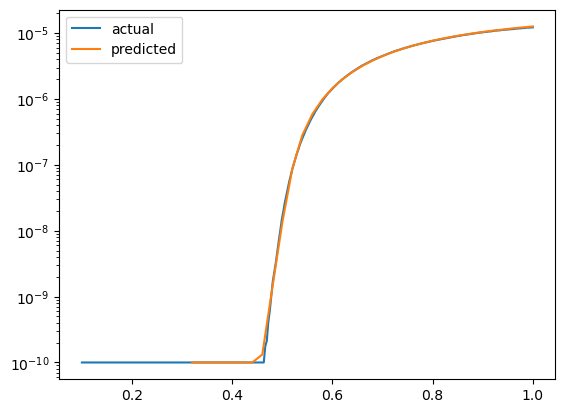

In [26]:
filename2 = 'test_measurements/predictionTestCurve.csv'
df2 = pd.read_csv(filename2)
predictedId = df2.iloc[:, 1].to_numpy()
predictedVg = df2.iloc[:, 0].to_numpy()
predictedId = np.where(abs(predictedId) < noiseFloor, global_min, predictedId)

filename = 'test_measurements/rvtnMeasurementData.csv' #actualTestCurve.csv
df2 = pd.read_csv(filename)
actualId = df2.iloc[:, 1].to_numpy()
actualVg = df2.iloc[:, 0].to_numpy()
actualId = np.where(abs(actualId) < noiseFloor, global_min, actualId)


fig = plt.figure()
plt.plot(actualVg, [abs(val) for val in actualId], label = 'actual')
plt.plot(predictedVg, [abs(val) for val in predictedId], label = 'predicted')
plt.legend(loc = 'best')
#plt.yscale('log')
plt.show()

In [24]:
! ngspice -b test_measurements/netlist_eglvt.sp

Error: bad set form in line
    sourcepath = ( . /usr/local/Cellar/ngspice/43/share/ngspice/scripts /usr/local/Cellar/ngspice/43/share/ngspice/scripts test_measurements /Users/olivias-local/cryo_modelling/test_measurements/HSPICE /Users/olivias-local/cryo_modelling/test_measurements/HSPICE /Users/olivias-local/cryo_modelling/test_measurements/HSPICE /Users/olivias-local/cryo_modelling/test_measurements/HSPICE /Users/olivias-local/cryo_modelling/test_measurements/HSPICE /Users/olivias-local/cryo_modelling/test_measurements/HSPICE /Users/Error: bad set form in line
    sourcepath = ( . /usr/local/Cellar/ngspice/43/share/ngspice/scripts /usr/local/Cellar/ngspice/43/share/ngspice/scripts test_measurements /Users/olivias-local/cryo_modelling/test_measurements/HSPICE /Users/olivias-local/cryo_modelling/test_measurements/HSPICE /Users/olivias-local/cryo_modelling/test_measurements/HSPICE /Users/olivias-local/cryo_modelling/test_measurements/HSPICE /Users/olivias-local/cryo_modelling/test_meas

In [20]:
import PySpice
print("PySpice version:", PySpice.__version__)

PySpice version: 1.5
